В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch.








In [1]:
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

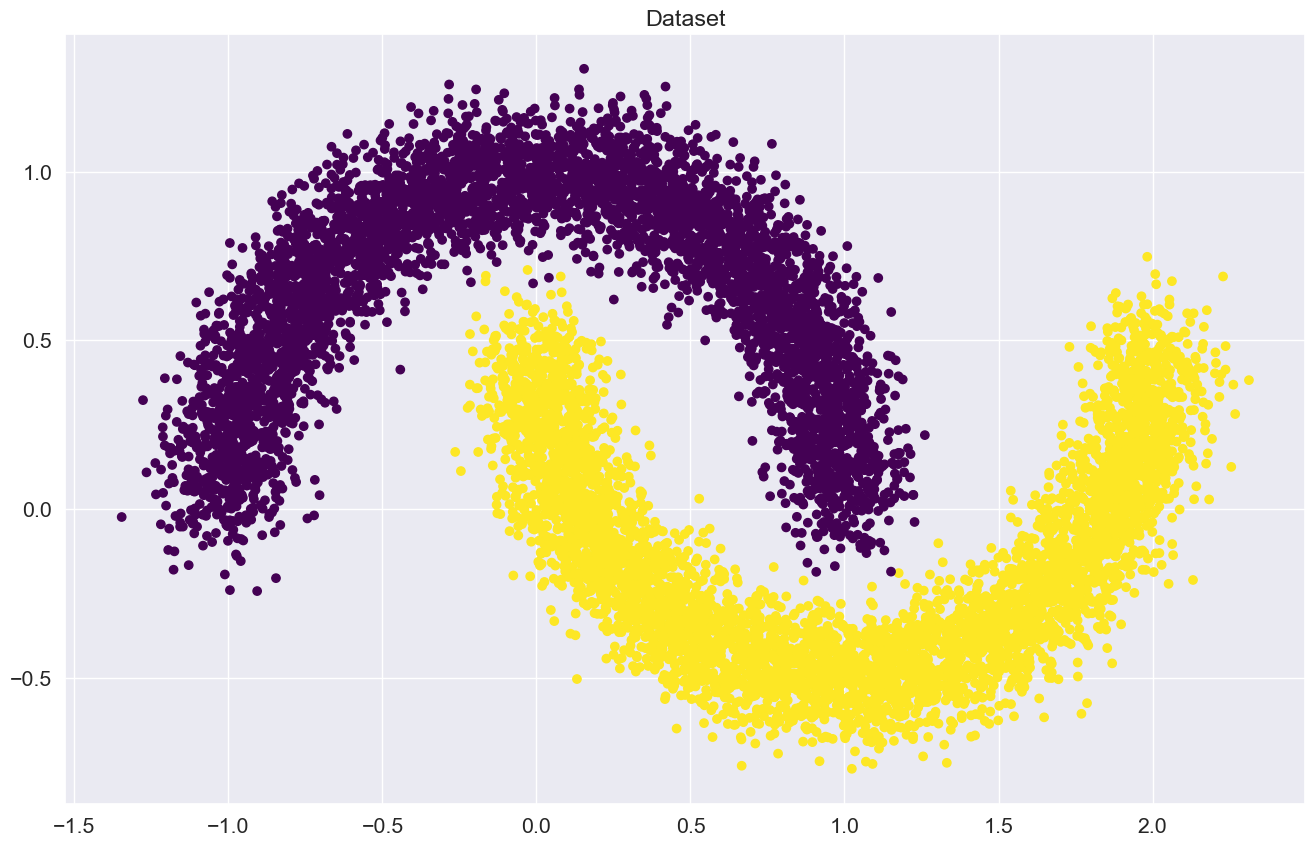

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t= torch.tensor(X_val, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression

**Напоминание**
На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):

        super().__init__()
        
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = torch.matmul(x, self.weights.t())
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

3 обучаемых параметра

2(features) + 1(biases) = 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [9]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.flatten(), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights

    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.859375
Iteration: 100
Batch accuracy: 0.8515625
Iteration: 200
Batch accuracy: 0.84375
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 523. Convergence. Stopping iterations.


### Визуализируем результаты

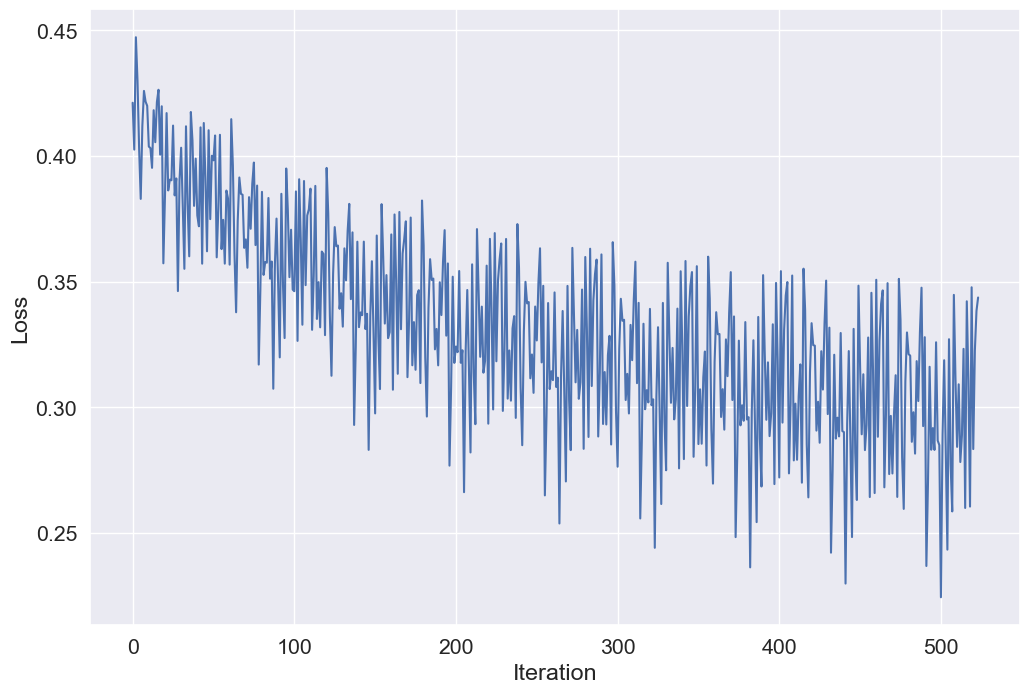

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

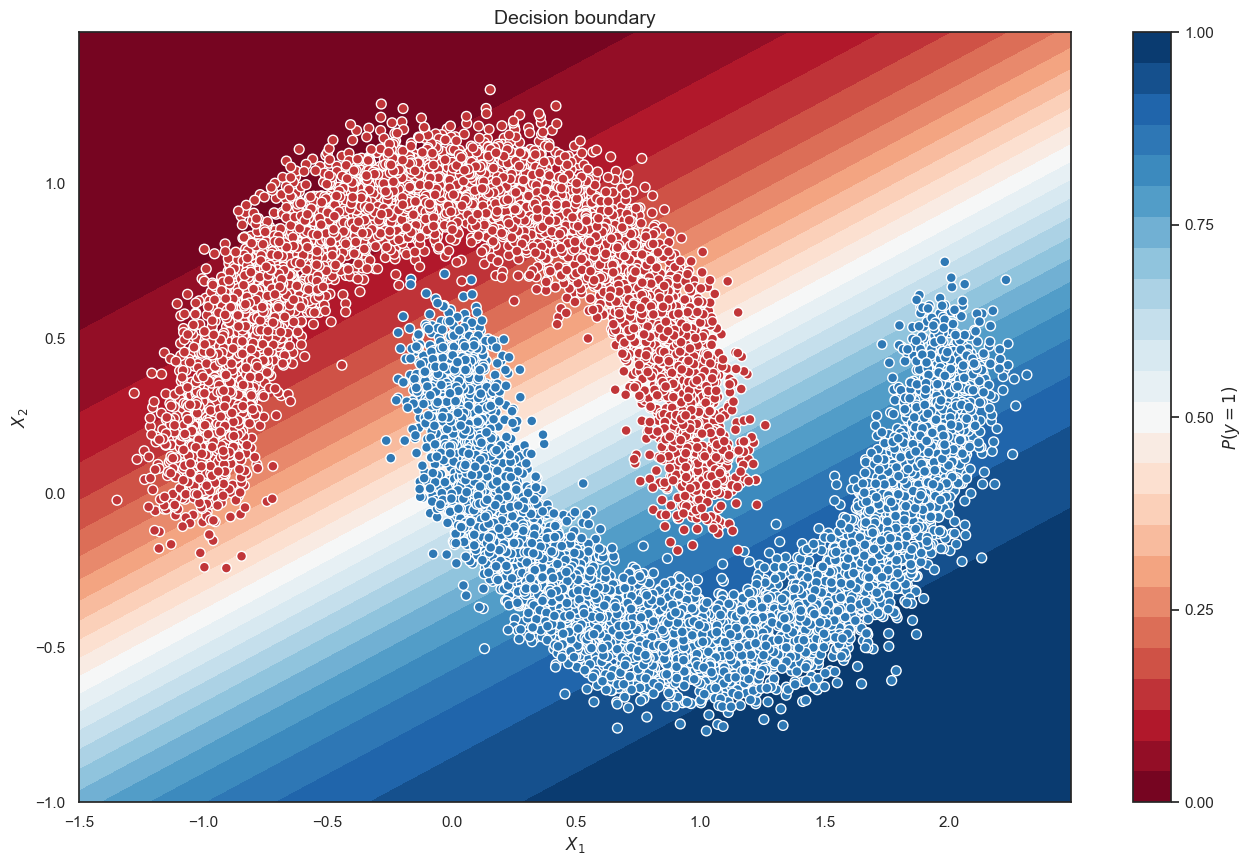

In [11]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [12]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [13]:
from sklearn.metrics import accuracy_score

val_predictions = predict(val_dataloader, linear_regression)

true_labels = np.array([])
for _, y_batch in val_dataloader:
    true_labels = np.hstack((true_labels, y_batch.numpy().flatten()))

accuracy = accuracy_score(true_labels, val_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8696


**Вопрос 2**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8696

# Часть 2. Датасет MNIST

In [14]:
import os

from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

valid_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

## Часть 2.1. Полносвязные нейронные сети

In [15]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [16]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10) 
)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)



```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [31]:
max_epochs = 10
elu_accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)  
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        elu_accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9873333333333333
Loader: valid. Accuracy: 0.9716
Epoch: 2
Loader: train. Accuracy: 0.9889
Loader: valid. Accuracy: 0.977
Epoch: 3
Loader: train. Accuracy: 0.98945
Loader: valid. Accuracy: 0.9758
Epoch: 4
Loader: train. Accuracy: 0.9909833333333333
Loader: valid. Accuracy: 0.9746
Epoch: 5
Loader: train. Accuracy: 0.9910666666666667
Loader: valid. Accuracy: 0.9725
Epoch: 6
Loader: train. Accuracy: 0.99035
Loader: valid. Accuracy: 0.9778
Epoch: 7
Loader: train. Accuracy: 0.9926666666666667
Loader: valid. Accuracy: 0.9781
Epoch: 8
Loader: train. Accuracy: 0.9919333333333333
Loader: valid. Accuracy: 0.9786
Epoch: 9
Loader: train. Accuracy: 0.9929666666666667
Loader: valid. Accuracy: 0.9743
Epoch: 10
Loader: train. Accuracy: 0.9923666666666666
Loader: valid. Accuracy: 0.977


In [20]:
print(elu_accuracy)

{'train': [0.90285, 0.95505, 0.9672833333333334, 0.9729, 0.97685, 0.9803666666666667, 0.9818333333333333, 0.9840166666666667, 0.9856333333333334, 0.9869], 'valid': [0.9521, 0.9626, 0.9721, 0.9645, 0.9681, 0.974, 0.9729, 0.9751, 0.9732, 0.975]}


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [26]:
class Identical(nn.Module):
    def forward(self, x):
        return x

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    
    for epoch in range(max_epochs):
        for k in ["train", "valid"]:
            epoch_correct = 0
            epoch_all = 0
            
            if k == "train":
                model.train()
            else:
                model.eval()
            
            for x_batch, y_batch in loaders[k]:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                
                with torch.set_grad_enabled(k == "train"):
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum().item()
                all = y_batch.size(0)
                epoch_correct += correct
                epoch_all += all
                
                if k == "train":
                    loss.backward()
                    optimizer.step()
            
            epoch_acc = epoch_correct / epoch_all
            accuracy[k].append(epoch_acc)
            print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
    
    return accuracy

In [27]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
thang_accuracy = test_activation_function(nn.Tanh)

Epoch: 1
Loader: train. Accuracy: 0.8731166666666667
Epoch: 1
Loader: valid. Accuracy: 0.9054
Epoch: 2
Loader: train. Accuracy: 0.8986833333333333
Epoch: 2
Loader: valid. Accuracy: 0.9138
Epoch: 3
Loader: train. Accuracy: 0.9044833333333333
Epoch: 3
Loader: valid. Accuracy: 0.9098
Epoch: 4
Loader: train. Accuracy: 0.90725
Epoch: 4
Loader: valid. Accuracy: 0.908
Epoch: 5
Loader: train. Accuracy: 0.9095666666666666
Epoch: 5
Loader: valid. Accuracy: 0.9161
Epoch: 6
Loader: train. Accuracy: 0.9106
Epoch: 6
Loader: valid. Accuracy: 0.9131
Epoch: 7
Loader: train. Accuracy: 0.9119333333333334
Epoch: 7
Loader: valid. Accuracy: 0.9067
Epoch: 8
Loader: train. Accuracy: 0.9131166666666667
Epoch: 8
Loader: valid. Accuracy: 0.9121
Epoch: 9
Loader: train. Accuracy: 0.91305
Epoch: 9
Loader: valid. Accuracy: 0.9068
Epoch: 10
Loader: train. Accuracy: 0.9146333333333333
Epoch: 10
Loader: valid. Accuracy: 0.9078
Epoch: 1
Loader: train. Accuracy: 0.8886333333333334
Epoch: 1
Loader: valid. Accuracy: 0.937


In [28]:
print(plain_accuracy, relu_accuracy, leaky_relu_accuracy, thang_accuracy)


{'train': [0.8731166666666667, 0.8986833333333333, 0.9044833333333333, 0.90725, 0.9095666666666666, 0.9106, 0.9119333333333334, 0.9131166666666667, 0.91305, 0.9146333333333333], 'valid': [0.9054, 0.9138, 0.9098, 0.908, 0.9161, 0.9131, 0.9067, 0.9121, 0.9068, 0.9078]} {'train': [0.8886333333333334, 0.9476666666666667, 0.9616333333333333, 0.9686166666666667, 0.9739, 0.9762166666666666, 0.97765, 0.9799166666666667, 0.9821666666666666, 0.9839666666666667], 'valid': [0.937, 0.9548, 0.9632, 0.9697, 0.9725, 0.9704, 0.9718, 0.9673, 0.9733, 0.9764]} {'train': [0.8912166666666667, 0.9504666666666667, 0.9639, 0.9696666666666667, 0.9737, 0.9767666666666667, 0.97995, 0.9818666666666667, 0.9838, 0.9839166666666667], 'valid': [0.9466, 0.9596, 0.9629, 0.9707, 0.9649, 0.9711, 0.9679, 0.9718, 0.9742, 0.9737]} {'train': [0.9038, 0.9526833333333333, 0.9604333333333334, 0.9669, 0.9691, 0.9716666666666667, 0.9715, 0.9743166666666667, 0.97465, 0.9744833333333334], 'valid': [0.9411, 0.9542, 0.9606, 0.9663, 0.

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

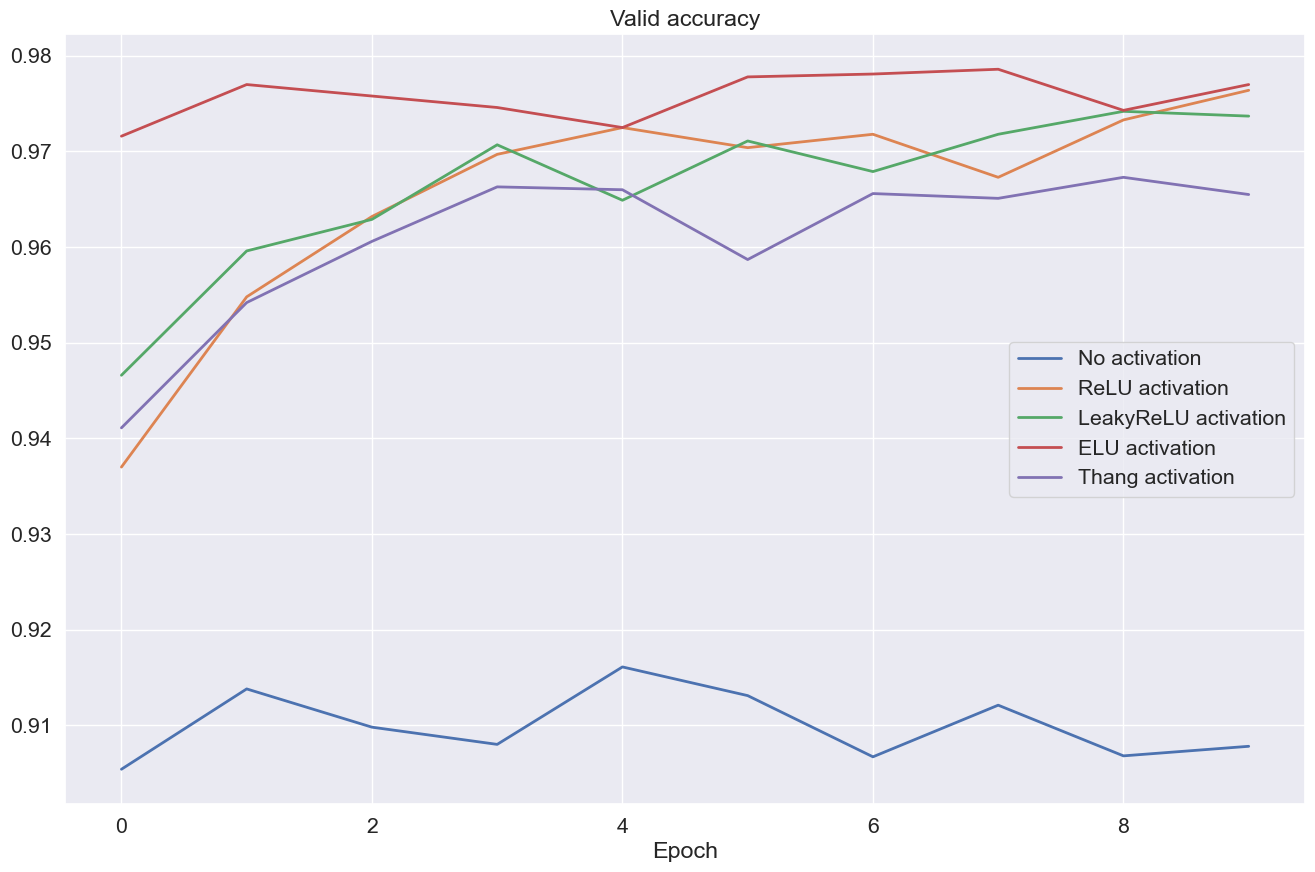

In [33]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), thang_accuracy['valid'], label="Thang activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 3.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU.